In [4]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

import pickle
import os

from models.ecoli.analysis import parcaAnalysisPlot
from wholecell.analysis.analysis_tools import exportFigure
from wholecell.utils import constants
from wholecell.utils import units

In [5]:
NE_path ='~/wcEcoli/models/ecoli/analysis/local_notebooks/C_limited_PDR_analyses_with_published_paper_data/previous_models/CLNE_files/CLNE_NE_rates_only.csv'
NE_rates_df = pd.read_csv(NE_path)
CL_path ='~/wcEcoli/models/ecoli/analysis/local_notebooks/C_limited_PDR_analyses_with_published_paper_data/previous_models/CLNE_files/CLNE_CL_rates_only.csv'
CL_rates_df = pd.read_csv(CL_path)

In [6]:
s1_path ='~/wcEcoli/models/ecoli/analysis/local_notebooks/C_limited_PDR_analyses_with_published_paper_data/supplementary_data/41467_2024_49920_MOESM4_ESM_ST1.xlsx'
table_s1_df = pd.read_excel(s1_path, skiprows=[0, 1, 2, 3])
df = pd.read_excel(s1_path, nrows=2, skiprows=[0, 1, 2], header = None)
media_condition_dict = dict(zip(df.iloc[1], df.iloc[0]))
clim_df = table_s1_df[['Protein ID', 'Gene names ', 'C-lim3_1', 'C-lim3_2',
       'C-lim6_1', 'C-lim6_2','C-lim12_1','C-lim12_2']] # exclude provided means because we will drop the "celing values"
# Create a deep copy
full_clim_values_df= clim_df.copy(deep=True)

In [7]:
#only dropping row if all clim columns are nan
clim_df.dropna(thresh = 6, inplace = True)
clim_df.reset_index(drop = True, inplace = True)

/var/folders/fg/mh5y1dgn2n5ft000p664m2z80000gq/T/ipykernel_52960/3587400491.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  clim_df.dropna(thresh = 6, inplace = True)


In [8]:
#will exclude "ceiling/undetermined values" marked by *
clim_df.loc[:, 'C-lim3_1':'C-lim12_2'] = clim_df.loc[:, 'C-lim3_1':'C-lim12_2'].astype(str)

/var/folders/fg/mh5y1dgn2n5ft000p664m2z80000gq/T/ipykernel_52960/2630270762.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  clim_df.loc[:, 'C-lim3_1':'C-lim12_2'] = clim_df.loc[:, 'C-lim3_1':'C-lim12_2'].astype(str)


In [9]:
clim_df = clim_df.applymap(lambda x: None if x.endswith('*') else x)

In [10]:
clim_df.loc[:, 'C-lim3_1':'C-lim12_2'] = clim_df.loc[:, 'C-lim3_1':'C-lim12_2'].astype(float)

In [11]:
clim_df.set_index(['Protein ID','Gene names '], inplace = True)

In [12]:
def find_max_column_custom(row):
    max_value = row.max()
    max_column = row[row == max_value].index[0]
    return max_column

clim_df['max_column'] = clim_df.apply(find_max_column_custom, axis=1)

In [13]:
# Find which proteins did NOT have their max half life in the 12 hr doubling time clim
non_12_mask = (clim_df['max_column'] != 'C-lim12_1') &(clim_df['max_column'] != 'C-lim12_2')
non_12_list = clim_df[non_12_mask].index

In [14]:
list_12 = clim_df[~non_12_mask].index

In [15]:
def calculate_difference(row):
    """Calculates the absolute difference between two values based on the 'max_column', handling NaN values."""

    columns = {'C-lim12': ('C-lim12_1', 'C-lim12_2'),
               'C-lim6': ('C-lim6_1', 'C-lim6_2'),
               'C-lim3': ('C-lim3_1', 'C-lim3_2')}

    for col, (col1, col2) in columns.items():
        if col in row['max_column']:
            return abs(row[col1] - row[col2]) if not np.isnan(row[col1]) and not np.isnan(row[col2]) else np.nan

    return np.nan

In [16]:
clim_df['difference'] = clim_df.apply(calculate_difference, axis=1)

In [17]:
clim_df['notes'] = None

In [18]:
# Keep assignment of max_column if replicates at the chosen doubling time column have a difference less than or equal to 3 hrs
clim_df['notes'][clim_df['difference'] <= 3] = 'consistent'

#262 assigned values have a difference greater than 3 hrs between replicates at the chosen doubling time column
#definitely assign to a value >6, but should it be the mean?
clim_df['notes'][(clim_df['difference'] > 3) 
        & clim_df['max_column'].str.contains('C-lim12') 
        & ((clim_df['C-lim12_1'] > 6) & (clim_df['C-lim12_2'] > 6))] = '> 6 hrs, inconsistent'

#assign...clim6 value if both replicates are present? Because clim12 value might be outlier/inconsistent
clim_df['notes'][(clim_df['difference'] > 3) 
        & clim_df['max_column'].str.contains('C-lim12') 
        & ((clim_df['C-lim12_1'] < 6) | (clim_df['C-lim12_2'] < 6))
        & ((clim_df['C-lim6_1'] > 3) & (clim_df['C-lim6_2'] > 3))] = '> 3 hrs, inconsistent'

#unsure what to assign, mean? This indicates inconsistent values 
clim_df['notes'][(clim_df['difference'] > 3) 
        & clim_df['max_column'].str.contains('C-lim12') 
        & ((clim_df['C-lim12_1'] < 6) | (clim_df['C-lim12_2'] < 6))
        & ((clim_df['C-lim6_1'] < 3) | (clim_df['C-lim6_2'] < 3))] = '< 3 hrs, inconsistent'


#300 assigned large values one have 1 replicate in that doubling time column

clim_df['notes'][clim_df['difference'].isna() 
        & clim_df['max_column'].str.contains('C-lim12') 
        & ((clim_df['C-lim12_1'] > 6) | (clim_df['C-lim12_2'] > 6))
        & ((clim_df['C-lim6_1'] > 3) & (clim_df['C-lim6_2'] > 3))] = '> 6 hrs, 1 replicate'
#unsure what to assign...clim6 value if both replicates are present? Because clim12 value might be outlier/inconsistent
clim_df['notes'][clim_df['difference'].isna() 
        & clim_df['max_column'].str.contains('C-lim12') 
         & ((clim_df['C-lim12_1'] < 6) | (clim_df['C-lim12_2'] < 6))
        & ((clim_df['C-lim6_1'] > 3) & (clim_df['C-lim6_2'] > 3))] = '> 3 hrs, 1 replicate'
#unsure what to assign...clim6 or clim3 values if both replicates are present? Mean of all values? Consistent short half life
clim_df['notes'][clim_df['difference'].isna() 
        & clim_df['max_column'].str.contains('C-lim12') 
        & ((clim_df['C-lim12_1'] < 6) | (clim_df['C-lim12_2'] < 6))
        & ((clim_df['C-lim6_1'] < 3) & (clim_df['C-lim6_2'] < 3))] = '< 3 hrs, 1 replicate'
#unsure what to assign... clim3 values if both replicates are present? Mean of all values? 
clim_df['notes'][clim_df['difference'].isna() 
        & clim_df['max_column'].str.contains('C-lim6') 
        & ((clim_df['C-lim6_1'] > 3) | (clim_df['C-lim6_2'] > 3))
        & ((clim_df['C-lim3_1'] > 0) & (clim_df['C-lim3_2'] > 0))] = '> 3 hrs, 1 replicate'
#unsure what to assign... clim3 values if both replicates are present? Mean of all values? Consistent short half life
clim_df['notes'][clim_df['difference'].isna() 
        & clim_df['max_column'].str.contains('C-lim6') 
        & ((clim_df['C-lim6_1'] < 3) | (clim_df['C-lim6_2'] < 3))
        & ((clim_df['C-lim3_1'] > 0) & (clim_df['C-lim3_2'] > 0))] = '< 3 hrs, 1 replicate'
#unsure what to assign... Mean of all values? Consistent short half life
clim_df['notes'][clim_df['difference'].isna() 
        & clim_df['max_column'].str.contains('C-lim3') 
        & ((clim_df['C-lim3_1'] > 0) | (clim_df['C-lim3_2'] > 0))] = '< 3 hrs, 1 replicate'

/var/folders/fg/mh5y1dgn2n5ft000p664m2z80000gq/T/ipykernel_52960/1631507830.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  clim_df['notes'][clim_df['difference'] <= 3] = 'consistent'
/var/folders/fg/mh5y1dgn2n5ft000p664m2z80000gq/T/ipykernel_52960/1631507830.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  clim_df['notes'][(clim_df['difference']>3)
/var/folders/fg/mh5y1dgn2n5ft000p664m2z80000gq/T/ipykernel_52960/1631507830.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guid

In [19]:
#unsure what to assign... clim3 values if both replicates are present? Mean of all values? Consistent short half life
clim_df['notes'][clim_df['notes'].isna()
        & clim_df['max_column'].str.contains('C-lim6') 
        & ((clim_df['C-lim6_1'] < 3) | (clim_df['C-lim6_2'] < 3))
        & ((clim_df['C-lim12_1'] < 6) | (clim_df['C-lim12_2'] < 6))] = '< 3 hrs, inconsistent'
#unsure what to assign... clim3 values if both replicates are present? Mean of all values? Consistent short half life
clim_df['notes'][clim_df['notes'].isna()
        & clim_df['max_column'].str.contains('C-lim6') 
        & ((clim_df['C-lim6_1'] > 3) & (clim_df['C-lim6_2'] > 3))
        & ((clim_df['C-lim12_1'] < 6) | (clim_df['C-lim12_2'] < 6))] = '> 3 hrs, inconsistent'
clim_df['notes'][clim_df['notes'].isna()
        & clim_df['max_column'].str.contains('C-lim6') 
        & ((clim_df['C-lim6_1'] > 3) | (clim_df['C-lim6_2'] > 3))
       ] = '> 3 hrs, inconsistent'
#unsure what to assign... clim3 values if both replicates are present? Mean of all values? Consistent short half life
clim_df['notes'][clim_df['notes'].isna()
        & clim_df['max_column'].str.contains('C-lim12') 
        & ((clim_df['C-lim12_1'] > 6) | (clim_df['C-lim12_2'] > 6))
        & ((clim_df['C-lim6_1'] > 3) | (clim_df['C-lim6_2'] > 3))] = '> 3 hrs, inconsistent'
#unsure what to assign... clim3 values if both replicates are present? Mean of all values? Consistent short half life
clim_df['notes'][clim_df['notes'].isna()
        & clim_df['max_column'].str.contains('C-lim12') 
        & ((clim_df['C-lim12_1'] < 6) | (clim_df['C-lim12_2'] < 6))
        & ((clim_df['C-lim6_1'] < 3) | (clim_df['C-lim6_2'] < 3))] = '< 3 hrs, inconsistent'
#unsure what to assign... clim3 values if both replicates are present? Mean of all values? Consistent short half life
clim_df['notes'][clim_df['notes'].isna()
        & clim_df['max_column'].str.contains('C-lim12') 
        & ((clim_df['C-lim12_1'] > 6) | (clim_df['C-lim12_2'] > 6))
        & ((clim_df['C-lim6_1'] < 3) | (clim_df['C-lim6_2'] < 3))] = 'inconsistent'
#unsure what to assign... clim3 values if both replicates are present? Mean of all values? Consistent short half life
clim_df['notes'][clim_df['notes'].isna()
        & clim_df['max_column'].str.contains('C-lim12') 
        & ((clim_df['C-lim12_1'] < 6) | (clim_df['C-lim12_2'] < 6))
        & ((clim_df['C-lim6_1'] > 3) | (clim_df['C-lim6_2'] > 3))] = '> 3hrs, inconsistent'
#unsure what to assign... clim3 values if both replicates are present? Mean of all values? Consistent short half life
clim_df['notes'][clim_df['notes'].isna()
        & clim_df['max_column'].str.contains('C-lim12') 
        & ((clim_df['C-lim12_1'] > 6) | (clim_df['C-lim12_2'] > 6))]= '> 3, inconsistent'

/var/folders/fg/mh5y1dgn2n5ft000p664m2z80000gq/T/ipykernel_52960/854705298.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  clim_df['notes'][clim_df['notes'].isna()
/var/folders/fg/mh5y1dgn2n5ft000p664m2z80000gq/T/ipykernel_52960/854705298.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  clim_df['notes'][clim_df['notes'].isna()
/var/folders/fg/mh5y1dgn2n5ft000p664m2z80000gq/T/ipykernel_52960/854705298.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returnin

In [20]:
clim_df['notes'] = clim_df['notes'].str.replace('> 3hrs, inconsistent', '> 3 hrs, inconsistent')

In [21]:
clim_df['notes'].unique()

array(['consistent', '> 6 hrs, 1 replicate', '> 3 hrs, inconsistent',
       '> 6 hrs, inconsistent', '< 3 hrs, inconsistent',
       '> 3 hrs, 1 replicate', '< 3 hrs, 1 replicate', 'inconsistent',
       '> 3, inconsistent'], dtype=object)

In [22]:
#use a dictionary to assign which values to use for the ultimate protein half life
# I will use the median of all available values beyond specified threshold for values that have only 1 replicate or are inconsistent

threshold_dict = {
    'consistent': None, 
    '> 6 hrs, 1 replicate': '> 6', 
    '> 3 hrs, inconsistent': '> 3',
    '> 6 hrs, inconsistent': '> 6', 
    '< 3 hrs, inconsistent': '< 3',
    '> 3 hrs, 1 replicate': '> 3',
    '< 3 hrs, 1 replicate': '< 3',
    'inconsistent': '> 0' }

In [23]:
clim_df['threshold_expr'] = clim_df['notes'].map(threshold_dict)

In [24]:
clim_df.reset_index(inplace = True)

In [25]:
clim_df.columns

Index(['Protein ID', 'Gene names ', 'C-lim3_1', 'C-lim3_2', 'C-lim6_1',
       'C-lim6_2', 'C-lim12_1', 'C-lim12_2', 'max_column', 'difference',
       'notes', 'threshold_expr'],
      dtype='object')

In [26]:
clim_df.columns[6:]

Index(['C-lim12_1', 'C-lim12_2', 'max_column', 'difference', 'notes',
       'threshold_expr'],
      dtype='object')

In [27]:
clim_long = clim_df[clim_df['notes'] != 'consistent'].melt(id_vars = ['Protein ID', 'Gene names ','notes', 'threshold_expr'], 
             value_vars = ['C-lim3_1', 'C-lim3_2', 'C-lim6_1','C-lim6_2', 'C-lim12_1', 'C-lim12_2'],
             var_name = 'replicate name',
             value_name = 'half life (hrs)').dropna()

In [28]:
clim_long

,Protein ID,Gene names,notes,threshold_expr,replicate name,half life (hrs)
0,sp|P00490|PHSM_ECOLI,malP,"> 6 hrs, 1 replicate",> 6,C-lim3_1,3.244616
1,sp|P00634|PPB_ECOLI,phoA,"> 6 hrs, 1 replicate",> 6,C-lim3_1,3.196812
2,sp|P00803|LEP_ECOLI,lepB,"> 3 hrs, inconsistent",> 3,C-lim3_1,3.629282
3,sp|P00903|PABA_ECOLI,pabA,"> 6 hrs, 1 replicate",> 6,C-lim3_1,3.273867
4,sp|P00954|SYW_ECOLI,trpS,"> 6 hrs, inconsistent",> 6,C-lim3_1,2.860747
...,...,...,...,...,...,...
3364,sp|P76461|ATOB_ECOLI,atoB,"> 6 hrs, 1 replicate",> 6,C-lim12_2,7.996852
3366,sp|P77309|YNEJ_ECOLI,yneJ,"> 3 hrs, inconsistent",> 3,C-lim12_2,8.266119
3368,sp|P77579|PTFC1_ECOLI,fryC,"> 6 hrs, 1 replicate",> 6,C-lim12_2,6.395996
3369,sp|P77754|SPY_ECOLI,spy,"> 3 hrs, inconsistent",> 3,C-lim12_2,4.816587


In [29]:
clim_long['notes'].unique()

array(['> 6 hrs, 1 replicate', '> 3 hrs, inconsistent',
       '> 6 hrs, inconsistent', '< 3 hrs, inconsistent',
       '> 3 hrs, 1 replicate', '< 3 hrs, 1 replicate', 'inconsistent'],
      dtype=object)

In [30]:
#if threshold above 6 then make half life <=6 = nan within that selection
clim_long['half life (hrs)'][(clim_long['threshold_expr']=='> 6') &(clim_long['half life (hrs)'] <= 6)]= np.nan
#if threshold above 3 then make half life <=3 = nan within that selection
clim_long['half life (hrs)'][(clim_long['threshold_expr']=='> 3') &(clim_long['half life (hrs)'] <= 3)]= np.nan
#if threshold below 3 then make half life >=3 = nan within that selection
clim_long['half life (hrs)'][(clim_long['threshold_expr']=='< 3') &(clim_long['half life (hrs)'] >= 3)]= np.nan

In [33]:
clim_long.dropna(inplace = True)

In [34]:
clim_long.columns

Index(['Protein ID', 'Gene names ', 'notes', 'threshold_expr',
       'replicate name', 'half life (hrs)'],
      dtype='object')

In [35]:
#if half life is not consistent, choose the median among available values per category in Protein ID
inconsistent_protein_medians = clim_long.groupby(['Protein ID', 'Gene names ','notes',
       'threshold_expr' ])['half life (hrs)'].median().reset_index()

In [36]:
inconsistent_protein_medians

,Protein ID,Gene names,notes,threshold_expr,half life (hrs)
0,sp|P00490|PHSM_ECOLI,malP,"> 6 hrs, 1 replicate",> 6,7.155026
1,sp|P00634|PPB_ECOLI,phoA,"> 6 hrs, 1 replicate",> 6,9.891235
2,sp|P00803|LEP_ECOLI,lepB,"> 3 hrs, inconsistent",> 3,4.771535
3,sp|P00903|PABA_ECOLI,pabA,"> 6 hrs, 1 replicate",> 6,8.09855
4,sp|P00954|SYW_ECOLI,trpS,"> 6 hrs, inconsistent",> 6,10.607478
...,...,...,...,...,...
550,sp|Q46925|CSDA_ECOLI,csdA,"> 6 hrs, inconsistent",> 6,10.777675
551,sp|Q47083|CBL_ECOLI,cbl,"< 3 hrs, 1 replicate",< 3,1.162972
552,sp|Q47537|TAUA_ECOLI,tauA,"> 6 hrs, inconsistent",> 6,11.389587
553,sp|Q47679|YAFV_ECOLI,yafV,"> 6 hrs, inconsistent",> 6,11.746857


In [37]:
consistent_clim_df = clim_df[clim_df['notes'] == 'consistent'].melt(id_vars = ['Protein ID', 'Gene names ','max_column', 'notes'], 
             value_vars = ['C-lim3_1', 'C-lim3_2', 'C-lim6_1','C-lim6_2', 'C-lim12_1', 'C-lim12_2'],
             var_name = 'replicate name',
             value_name = 'half life (hrs)').dropna()

In [38]:
#only keep half life with replicate name that matches max_column
consistent_protein_medians = consistent_clim_df[consistent_clim_df['max_column']== consistent_clim_df['replicate name']]

In [40]:
consistent_protein_medians.rename(columns = {'max_column': 'assignment'}, inplace = True)
inconsistent_protein_medians.rename(columns = {'threshold_expr': 'assignment'}, inplace = True)

/var/folders/fg/mh5y1dgn2n5ft000p664m2z80000gq/T/ipykernel_52960/2210701067.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  consistent_protein_medians.rename(columns = {'max_column': 'assignment'}, inplace = True)


In [41]:
gupta_protein_half_lifes = pd.concat([consistent_protein_medians[['Protein ID', 'Gene names ', 'notes', 'assignment', 'half life (hrs)']], 
                                      inconsistent_protein_medians])

In [43]:
final_path = '~/wcEcoli/models/ecoli/analysis/local_notebooks/C_limited_PDR_analyses_with_published_paper_data/Clim_sorting_combos/Clim2/Clim2'
gupta_protein_half_lifes.to_csv(final_path, index=False)

In [44]:
gupta_protein_half_lifes

,Protein ID,Gene names,notes,assignment,half life (hrs)
450,sp|P0A9P6|DEAD_ECOLI,deaD,consistent,C-lim3_1,1.642305
472,sp|P0A9X9|CSPA_ECOLI,cspA,consistent,C-lim3_1,1.793323
654,sp|P0ADG1|ILVM_ECOLI,ilvM,consistent,C-lim3_1,1.244372
1046,sp|P24216|FLID_ECOLI,fliD,consistent,C-lim3_1,1.485761
1180,sp|P32053|INTA_ECOLI,intA,consistent,C-lim3_1,1.3136
...,...,...,...,...,...
550,sp|Q46925|CSDA_ECOLI,csdA,"> 6 hrs, inconsistent",> 6,10.777675
551,sp|Q47083|CBL_ECOLI,cbl,"< 3 hrs, 1 replicate",< 3,1.162972
552,sp|Q47537|TAUA_ECOLI,tauA,"> 6 hrs, inconsistent",> 6,11.389587
553,sp|Q47679|YAFV_ECOLI,yafV,"> 6 hrs, inconsistent",> 6,11.746857


In [ ]:
# i need to figure out how to match the chosen median value to the chemostat condition it was growing in

In [45]:
gupta_protein_half_lifes

,Protein ID,Gene names,notes,assignment,half life (hrs)
450,sp|P0A9P6|DEAD_ECOLI,deaD,consistent,C-lim3_1,1.642305
472,sp|P0A9X9|CSPA_ECOLI,cspA,consistent,C-lim3_1,1.793323
654,sp|P0ADG1|ILVM_ECOLI,ilvM,consistent,C-lim3_1,1.244372
1046,sp|P24216|FLID_ECOLI,fliD,consistent,C-lim3_1,1.485761
1180,sp|P32053|INTA_ECOLI,intA,consistent,C-lim3_1,1.3136
...,...,...,...,...,...
550,sp|Q46925|CSDA_ECOLI,csdA,"> 6 hrs, inconsistent",> 6,10.777675
551,sp|Q47083|CBL_ECOLI,cbl,"< 3 hrs, 1 replicate",< 3,1.162972
552,sp|Q47537|TAUA_ECOLI,tauA,"> 6 hrs, inconsistent",> 6,11.389587
553,sp|Q47679|YAFV_ECOLI,yafV,"> 6 hrs, inconsistent",> 6,11.746857


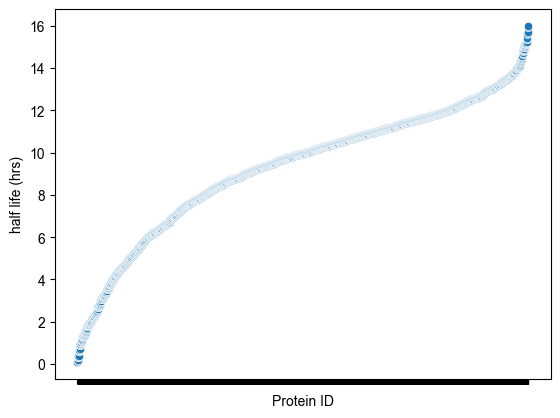

In [46]:
ax = sns.scatterplot(x='Protein ID', y='half life (hrs)',
                     data= gupta_protein_half_lifes.sort_values(by='half life (hrs)'))

# Set the y-axis labels to an empty list
ax.set_xticklabels([])

plt.show()

/Users/miagrahn/.pyenv/versions/wcEcoli3/lib/python3.11/site-packages/seaborn/categorical.py:3399: UserWarning: 83.1% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/Users/miagrahn/.pyenv/versions/wcEcoli3/lib/python3.11/site-packages/seaborn/categorical.py:3399: UserWarning: 35.2% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/Users/miagrahn/.pyenv/versions/wcEcoli3/lib/python3.11/site-packages/seaborn/categorical.py:3399: UserWarning: 25.0% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/Users/miagrahn/.pyenv/versions/wcEcoli3/lib/python3.11/site-packages/seaborn/categorical.py:3399: UserWarning: 44.0% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarni

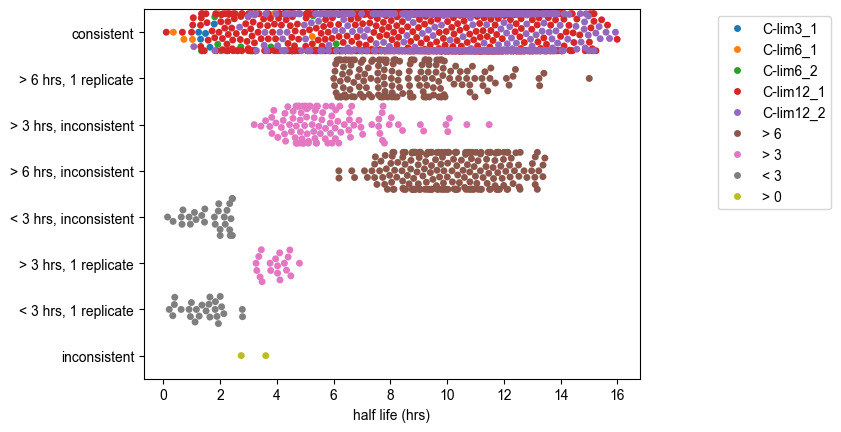

In [47]:
# Draw a categorical scatterplot to show each observation
ax = sns.swarmplot(data=gupta_protein_half_lifes, 
                   x= 'half life (hrs)', y= 'notes', hue= 'assignment')
ax.set(ylabel="");
legend = ax.legend(loc='upper right', bbox_to_anchor=(1.4, 1));

In [48]:
clim_long_all_values= clim_df.melt(id_vars = ['Protein ID', 'Gene names ','notes', 'threshold_expr'], 
             value_vars = ['C-lim3_1', 'C-lim3_2', 'C-lim6_1','C-lim6_2', 'C-lim12_1', 'C-lim12_2'],
             var_name = 'replicate name',
             value_name = 'half life (hrs)')

In [49]:
clim_long_all_values['notes'].unique()

array(['consistent', '> 6 hrs, 1 replicate', '> 3 hrs, inconsistent',
       '> 6 hrs, inconsistent', '< 3 hrs, inconsistent',
       '> 3 hrs, 1 replicate', '< 3 hrs, 1 replicate', 'inconsistent',
       '> 3, inconsistent'], dtype=object)

/var/folders/fg/mh5y1dgn2n5ft000p664m2z80000gq/T/ipykernel_52960/3739113948.py:4: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right');


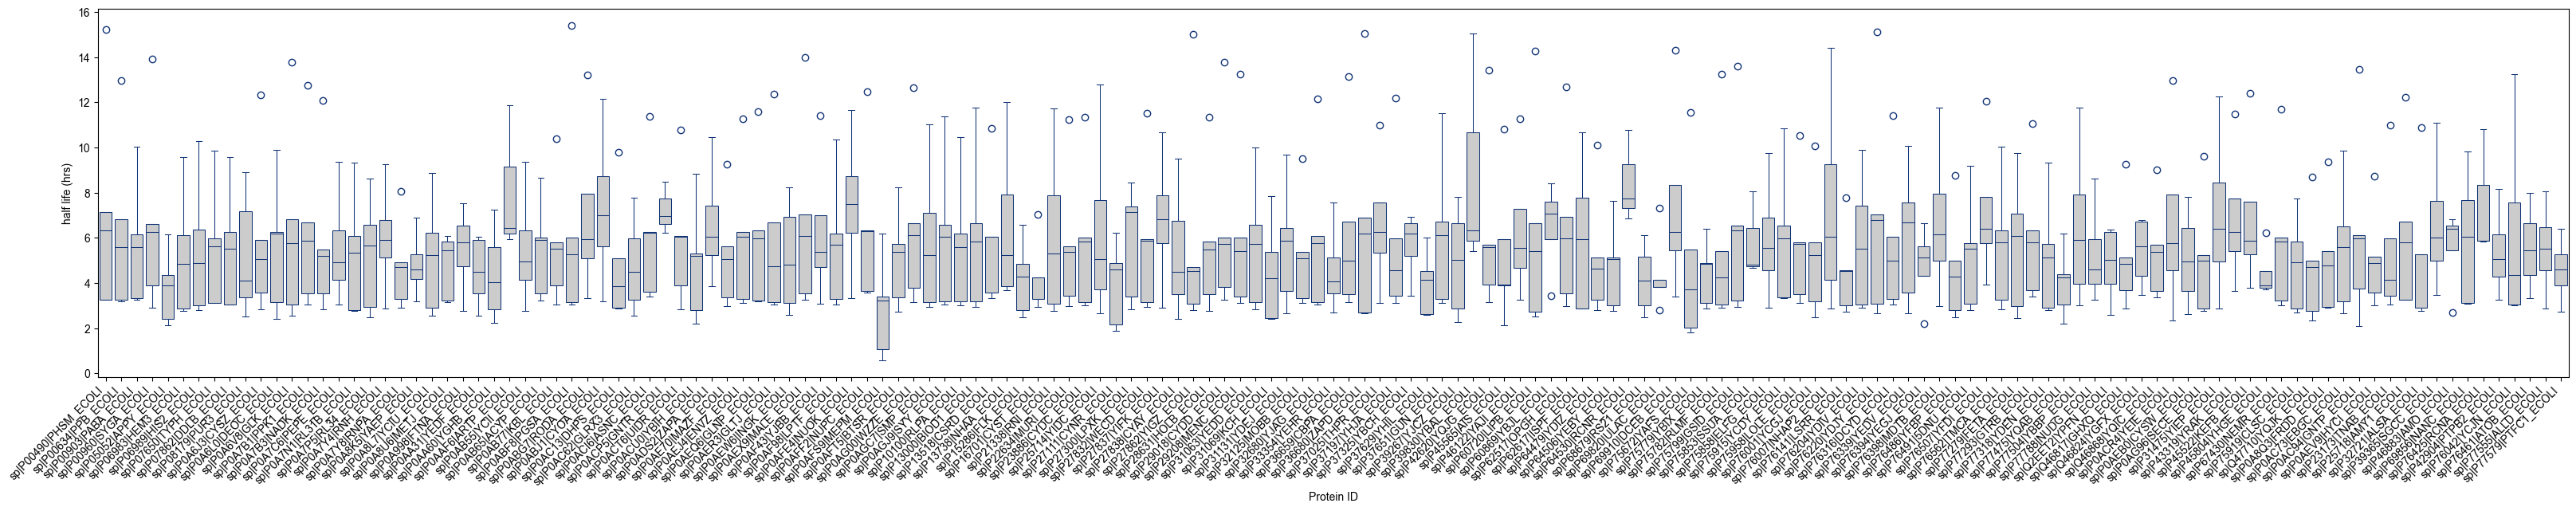

In [50]:
fig, ax = plt.subplots(figsize=(40, 6))
sns.boxplot(data=clim_long_all_values[clim_long_all_values['notes']=='> 6 hrs, 1 replicate'], 
            x='Protein ID', y='half life (hrs)', color='.8', linecolor='#137', linewidth=.75, ax = ax)
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right');